In [230]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [239]:
filename = "2023-10-06 21_14_26.393518.png"
depth_raw = cv2.imread('data/depth_raw/depth_raw' + filename, cv2.IMREAD_UNCHANGED)
depth_img = cv2.imread('data/depth_modified/depth_modified' + filename, cv2.IMREAD_UNCHANGED)

bgr_img = cv2.imread('data/rgb/rgb_img' + filename)
lab_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2LAB)
hsv_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV)

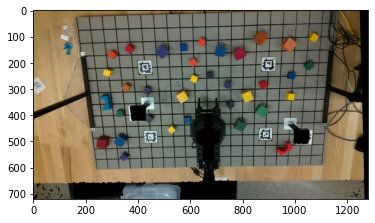

In [240]:
# Step 1
# remove height > 100
lower = -100
upper = 100
depth_seg = cv2.inRange(depth_img, lower, upper)
mask_three_channel = cv2.merge([depth_seg, depth_seg, depth_seg])
bgr_img_remove_height = cv2.bitwise_and(bgr_img, mask_three_channel)
plt.imshow(bgr_img_remove_height)
plt.show()

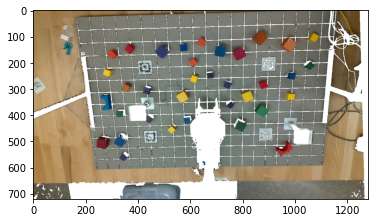

In [241]:
# Step 2
# remove shadow

black_mask = cv2.inRange(bgr_img_remove_height, np.array([0, 0, 0]), np.array([50, 50, 50]))
white_img = np.ones_like(bgr_img_remove_height) * 255
result = cv2.bitwise_and(bgr_img_remove_height, bgr_img_remove_height, mask=~black_mask)
result += cv2.bitwise_and(white_img, white_img, mask=black_mask)
plt.imshow(result)
plt.show()

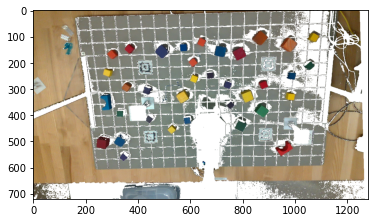

In [242]:
# Step 3
# RGB filter
rgb_mask = cv2.inRange(bgr_img, np.array([80,80,70]), np.array([110, 120, 110]))
white_img = np.ones_like(result) * 255
result = cv2.bitwise_and(result, result, mask=~rgb_mask)
result += cv2.bitwise_and(white_img, white_img, mask=rgb_mask)
plt.imshow(result)
plt.show()

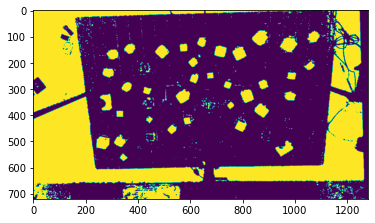

In [243]:
# Step 4
# hsv mask
hsv_img = cv2.cvtColor(result, cv2.COLOR_BGR2HSV)

hsv_mask = cv2.inRange(hsv_img, np.array([0,43,46]), np.array([180, 255, 255]))
hsv_mask = cv2.medianBlur(hsv_mask, 3)

plt.imshow(hsv_mask)
plt.show()

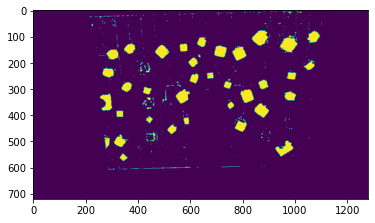

In [244]:
# Step 5
# add mask
boundary = [np.array([[ 217,   25],
            [ 288,  606],
            [1055,  590],
            [1107,	0]]), np.array([[592, 320],
            [602, 599],
            [743, 596],
            [743, 316]])]
mask = np.zeros_like(hsv_mask, dtype=np.uint8)
cv2.fillPoly(mask, [boundary[0]], 255)
cv2.fillPoly(mask, [boundary[1]], 0)
masked_hsv = cv2.bitwise_and(hsv_mask, mask)
plt.imshow(masked_hsv)
plt.show()

There is 35 blocks


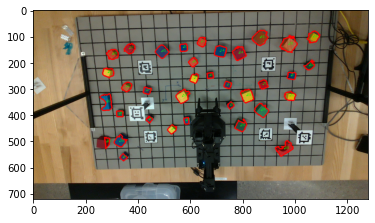

In [245]:
# Step 6
# find countor, filter countor
contours, _ = cv2.findContours(masked_hsv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
font = cv2.FONT_HERSHEY_SIMPLEX
canvas = bgr_img.copy()
i = 0
center_list = []
for contour in contours:
    M = cv2.moments(contour)
    if M['m00'] < 200 or abs(M["m00"]) > 7000:
        continue
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    center_list.append([cx, cy])
    block_ori = cv2.minAreaRect(contour)[2]
    cv2.circle(canvas, (cx, cy), 2, (0, 255, 0), -1)
    cv2.putText(canvas, str(int(block_ori)), (cx, cy), font, 0.4, (0, 255, 0), thickness=1)
    cv2.drawContours(canvas, [contour], -1, (255, 0, 0), 3)
print(f"There is {len(center_list)} blocks")
cv2.imwrite("data/result.png", canvas)
plt.imshow(canvas)
plt.show()

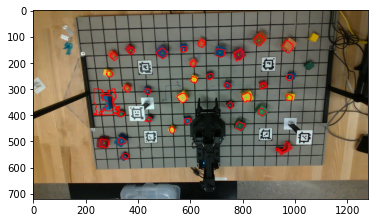

In [238]:
# # Step 7 (deprecate)
# # use depth to refine contours
# side = 100
# canvas = bgr_img.copy()

# for center in center_list:
#     cx, cy = center
#     cz = depth_img[cy, cx]
#     top_left_y = int(cy - side / 2)
#     top_left_x = int(cx - side / 2)
#     bottom_right_y = int(cy + side / 2)
#     bottom_right_x = int(cx + side / 2)

#     sub_region = depth_img[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
#     lower = int(cz - 3)
#     upper = int(cz + 3)
#     depth_seg = cv2.inRange(sub_region, lower, upper)
#     contours, _ = cv2.findContours(depth_seg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]

#     for contour in contours:
#         M = cv2.moments(contour)
#         if M['m00'] < 200 or abs(M["m00"]) > 7000:
#             continue
#         contour += [cx - int(side/2), cy - int(side /2)]
#         new_cx = int(M['m10']/M['m00'])
#         new_cy = int(M['m01']/M['m00'])
#         # block_ori = cv2.minAreaRect(contour)[2]
#         cv2.circle(canvas, (new_cx + cx - int(side/2), new_cy + cy - int(side/2)), 2, (0, 255, 0), -1)
#         # cv2.putText(canvas, str(int(block_ori)), (cx, cy), font, 0.4, (0, 255, 0), thickness=1)
#         cv2.drawContours(canvas, [contour], -1, (255, 0, 0), 2)

# cv2.imwrite("data/result_depth_modifid.png", canvas)
# plt.imshow(canvas)
# plt.show()